In [116]:
import os
import urllib
import urllib.request
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import sklearn
from pandas.plotting import scatter_matrix
from google.colab import files
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import  SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import LabelEncoder

In [117]:
os.listdir()

['.config', 'test_scores.csv', 'sample_data']

In [118]:

data_location = 'test_scores.csv' #location of Data/csv file

def load_test_scores(data = data_location ): 
  df = pd.read_csv(data_location)
  return df

df = load_test_scores()


n_student refers to the number of students in this students class. We can change this column name to n_students_in_class.

In [119]:
df.rename(columns={"n_student":'n_students_in_class'} , inplace=True)
# df.drop(axis=1 , columns=['student_id'] , inplace=True )

In [120]:
df.isnull().sum()

school                 0
school_setting         0
school_type            0
classroom              0
teaching_method        0
n_students_in_class    0
student_id             0
gender                 0
lunch                  0
pretest                0
posttest               0
dtype: int64

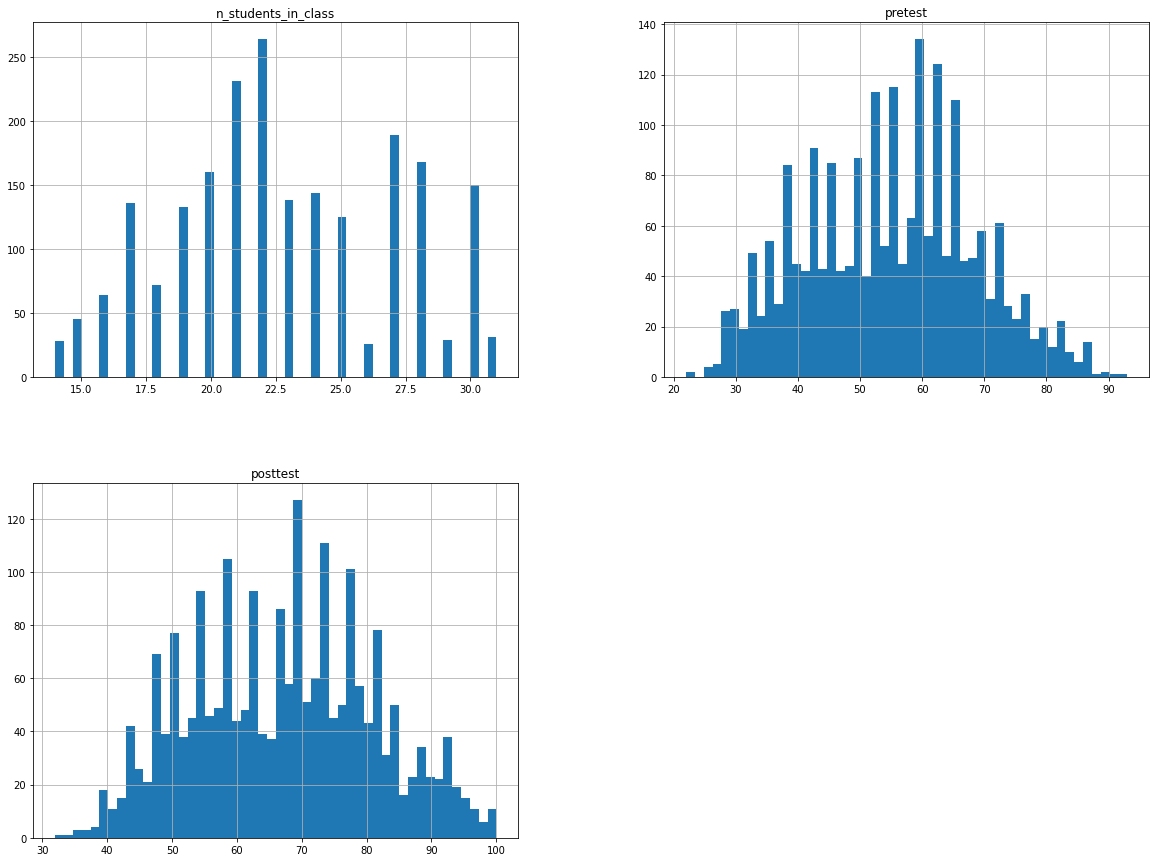

In [121]:
%matplotlib inline 
df.hist(bins=50 , figsize=(20,15) )
plt.show()

Let's get the [pearson correlation](https://www.spss-tutorials.com/pearson-correlation-coefficient/) between these features.

In [122]:
corr_matrix = df.corr()
corr_matrix['posttest'].sort_values(ascending=False)

posttest               1.000000
pretest                0.950884
n_students_in_class   -0.504886
Name: posttest, dtype: float64

The numbers above tell us that the pretest and posttest values are very closely and positively related. As for the n_students_in_class the correlation is negative but fairly strong.



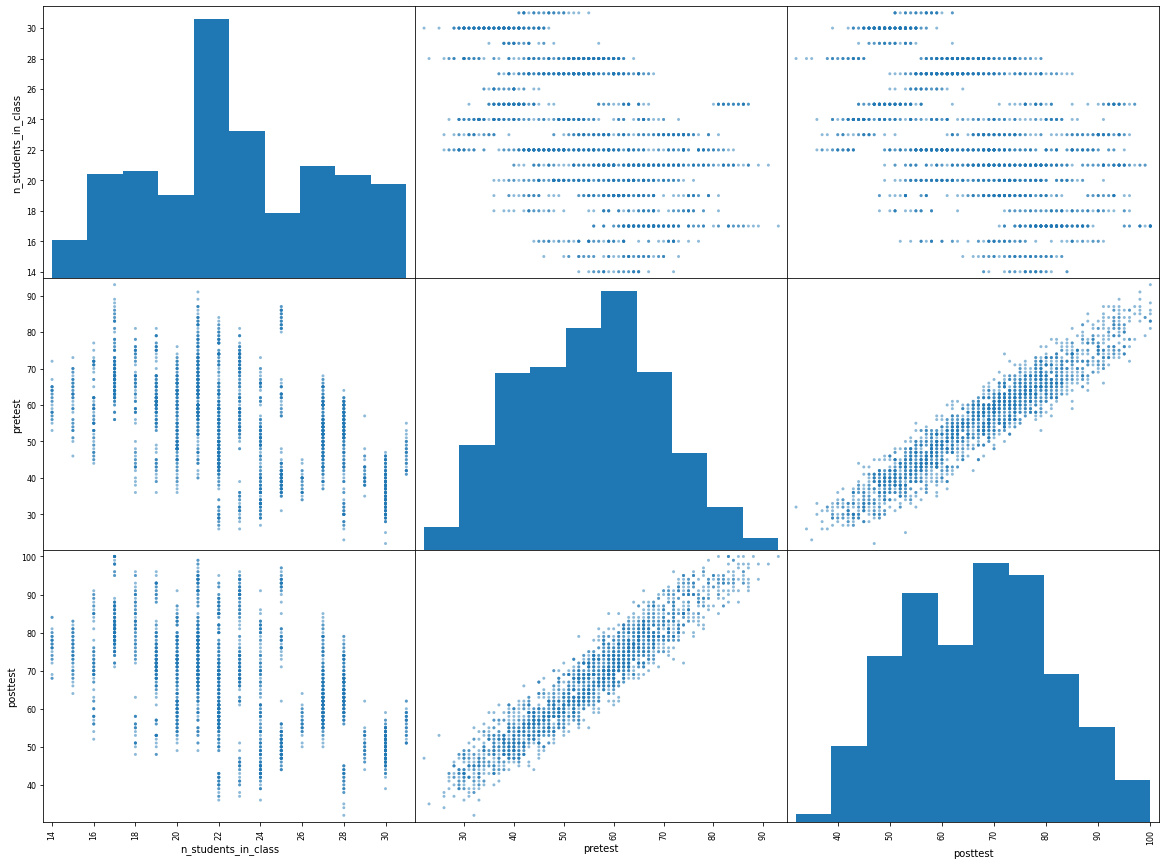

In [123]:
%matplotlib inline 
pd.plotting.scatter_matrix(df, figsize=(20,15) )
plt.show()

From the scatter plot above we can view the horizontal/vertical lines in any plot related to n_students_in_class. This can give us an indication that maybe we should turn this column into a categorical variable where the number of n_students_in_class relates to the
category. 

OR

We can actually drop the n_students_in_class columns. This is because we already have a column called classroom. Since all the classrooms with the same name have the same number of students in them, the n_students_in_class can be droppped.


In [124]:
def convert_column_to_cat(df , column_to_convert='n_students_in_class' , new_column_name = 'students_per_classroom'):#initial purpose is to convert n_student to a categorical var
  class_sizes = df.n_students_in_class.unique()
  try:
    for i in class_sizes:
      df.replace({column_to_convert : i} , str(i) , inplace=True)
    if df.loc[:,column_to_convert].dtype == 'O':
        print(" {}'s data converted to Object type".format(column_to_convert))
  except Exception as e:
    print(e)

# convert_column_to_cat(df)


In [125]:
# cond = df.n_students_in_class ==20.0
# only_20_perclassroom = df[cond]
# only_20_perclassroom.classroom.unique()

In [126]:
df.drop('n_students_in_class', inplace=True , axis=1)
# df.columns

Now we are going to have to split our dataset into a train set and a test set. Based on the Pearson Correlation Coefficient, the pretest scores are a very strong indicator of the posttest scores. Hence we shall use Stratified Shuffling to split our dataset. That way our model will be trained on data with a distribution is similar to that of actual data.

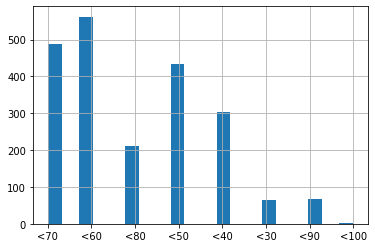

In [127]:

model_this_distribution = pd.cut(df['pretest'],bins=[0 , 30. , 40. , 50. , 60. , 70. ,80. , 90. ,np.inf ],
labels = ['<30' , '<40','<50','<60','<70','<80','<90' , '<100'])

%matplotlib inline 
model_this_distribution.hist(grid=True, bins=20, rwidth=0.9)
plt.show()


In [128]:

split = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)
for train,test in split.split(df , model_this_distribution):
  strat_train_set = df.loc[train]
  strat_test_set = df.loc[test]

**Data Transformation**

---


**Handling Numerical Null values**

To handle null values, we shall use the mean strategy.






**Handling Categorical  Columns**

Columns to encode :
  1. gender
  2. school_type
  3. teaching_method
  4. lunch(Whether the student qualifies for reduced/free lunch or not)
  5. school_setting


For items 1-4 the values are binary so we can drop each column from the 2 columns produced when each one of the 4 columns are encoded.
For school_settings column we wouldnt need to do this


In [129]:
OneHotEncoder_Instance = OneHotEncoder()
df_Encoded = OneHotEncoder_Instance.fit_transform(df[['gender' , 'school_type' , 'teaching_method' , 'lunch' , 'school_setting' ]])
df_Encoded = pd.DataFrame.sparse.from_spmatrix(df_Encoded ).drop(axis=1 , columns=[0,2,4,6]).rename(columns={1: "gender", 3: "school_type" , 5:'teaching_method' , 7:'lunch' , 8:'Rural' , 9:'Suburban' , 10:'Urban'} )



In [130]:
df_Encoded

,gender,school_type,teaching_method,lunch,Rural,Suburban,Urban
0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,1.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,1.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...
2128,0.0,1.0,1.0,0.0,0.0,0.0,1.0
2129,0.0,1.0,1.0,1.0,0.0,0.0,1.0
2130,0.0,1.0,1.0,1.0,0.0,0.0,1.0
2131,1.0,1.0,1.0,1.0,0.0,0.0,1.0


This set of code above works well. We shall incorporate this into a custom transformer.




In [131]:

class HotEncodingCleaner(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
      df = pd.DataFrame.sparse.from_spmatrix(X )
      df.drop(axis=1 , columns=[0,2,4,6]  , inplace=True)
      
      return df

In [132]:
categorical_attributes = ['gender' , 'school_type' , 'teaching_method' , 'lunch' , 'school_setting' ]
Ordinal_encoding_attributes = ['school' , 'classroom']
num_attributes = ['pretest' , 'posttest' ]


cat_pipeline = Pipeline([
        
        ("cat", OneHotEncoder()),
        ('custom' , HotEncodingCleaner())
    ])

Ordinal_pipeline = Pipeline([  
        ('ordinal' ,  OrdinalEncoder()),  
    ])

full_pipeline = ColumnTransformer( [
        ("cat_pipeline", cat_pipeline,  categorical_attributes ),
        ("Ordinal_pipeline", Ordinal_pipeline , Ordinal_encoding_attributes),
        ('imputer', SimpleImputer(strategy="mean") , num_attributes ),
    ] , remainder='passthrough')

Now we shall apply this full pipeline to our stratified_train_set and then we will make the transformed DataFrame more intuitive.

We will also isolate the input data and the labels.

In [133]:
strat_train_treated = full_pipeline.fit_transform(strat_train_set)
strat_train_treated_df = pd.DataFrame(strat_train_treated , columns=['gender' , 'school_type' , 'teaching_method' , 'lunch' , 'Rural' , 'Suburban' , 'Urban' , 'school' , 'classroom' , 'pretest' , 'posttest' ,  'student_id' ] )
strat_train_treated_prepared  = strat_train_treated_df.drop(columns=['posttest' , 'student_id'   ])
strat_train_treated_labels  = strat_train_treated_df.loc[:,['posttest']]

Visualizing our Input and Labels for the training set.

In [134]:
print(strat_train_treated_prepared,'\n',strat_train_treated_labels)

     gender school_type teaching_method lunch  ... Urban school classroom pretest
0         0           1               0     0  ...     0     21        81      73
1         1           1               1     1  ...     1      8         3      48
2         0           0               0     0  ...     0     17        43      72
3         1           1               1     1  ...     0      6        44      47
4         0           1               1     1  ...     0     13        40      66
...     ...         ...             ...   ...  ...   ...    ...       ...     ...
1701      1           1               0     0  ...     0     16        54      74
1702      0           1               1     1  ...     0     11        12      49
1703      1           1               1     0  ...     0     13        87      59
1704      1           0               1     1  ...     0     18        50      53
1705      0           0               1     0  ...     1      2        62      67

[1706 rows x 10

In [135]:
forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(strat_train_treated_prepared , strat_train_treated_labels)
predictions_train_set = forest_reg.predict(strat_train_treated_prepared)
forestreg_rmse_train = np.sqrt(mean_squared_error(strat_train_treated_labels , predictions_train_set  ))
print('The RMSE on the training set is {}'.format(forestreg_rmse_train))

The RMSE on the training set is 1.673026573143772


Decent RMSE on the training set, lets see how this model performs on our test set.

In [136]:
strat_test_treated = full_pipeline.transform(strat_test_set)
strat_test_treated_df = pd.DataFrame(strat_test_treated , columns=['gender' , 'school_type' , 'teaching_method' , 'lunch' , 'Rural' , 'Suburban' , 'Urban' , 'school' , 'classroom' , 'pretest' , 'posttest' ,  'student_id' ] )
strat_test_treated_prepared  = strat_test_treated_df.drop(columns=['student_id' , 'posttest' ])
strat_test_treated_labels  = strat_test_treated_df.loc[:,['posttest']]

Visualizing our Input and Labels for the test set.

In [137]:
print(strat_test_treated_prepared , '\n' , strat_test_treated_labels )

    gender school_type teaching_method lunch  ... Urban school classroom pretest
0        0           0               1     1  ...     1      0        96      56
1        1           0               0     1  ...     1     10         8      43
2        0           1               0     1  ...     0      6        55      60
3        0           1               1     1  ...     0      6        95      55
4        0           0               1     1  ...     1     10         9      42
..     ...         ...             ...   ...  ...   ...    ...       ...     ...
422      1           0               0     0  ...     1      9        25      73
423      1           0               0     1  ...     1     10         8      39
424      1           1               1     0  ...     0     19        13      39
425      0           0               1     1  ...     0      1        80      61
426      0           0               1     0  ...     0     17        21      59

[427 rows x 10 columns] 
  

In [138]:
predictions_test_set = forest_reg.predict(strat_test_treated_prepared)
forestreg_rmse_test = np.sqrt(mean_squared_error(strat_test_treated_labels , predictions_test_set  ))
print('The RMSE on the test set is {}'.format(forestreg_rmse_test))

The RMSE on the test set is 3.351896223717534


A RMSE of 3.37(3 s.f) is fairly decent.
However, RMSE alone may not be a good enough metric to evaluate our model's accuracy. For this we can use K-fold cross-validation.



**Evaluating using K-fold cross-validation**


In K-fold cross validation we split the training set randomly into 
K number of folds of equal size or thereabout.(K is set as cv in the cross_val_score Instance) Then we train and evaluate our lin_regressor 10 times. Each time, we pick 9 of the folds to train the lin_regressor on and then test it on the fold we did not pick.


For cross-validation, Scikit-Learn expects a utility function(greater is better) instead of a cost function(smaller is better). root_mean_squared_error is a cost function so its value will be negative when calculated by the cross-validator. Hence, scoring="neg_root_mean_squared_error". As shown below there is a simple workaround.

In [139]:
def scores_breakdown(scores_Linear , name=''): #A simple function to evaluate our k-fold scores
  scores_mean = scores_Linear.mean()
  scores_std = scores_Linear.std()
  print('Mean and Standard deviation of the k-fold scores of the {} set is {} and {} respectively'.format(name , scores_mean , scores_std ))


In [140]:
cross_val_score_train = cross_val_score(forest_reg, strat_train_treated_prepared , strat_train_treated_labels , scoring="neg_root_mean_squared_error", cv=10)
cross_val_score_train = -cross_val_score_train
scores_breakdown(cross_val_score_train , name='train')


Mean and Standard deviation of the k-fold scores of the train set is 3.2806031868013164 and 0.14221049544482672 respectively


In [141]:
cross_val_score_test = cross_val_score(forest_reg, strat_test_treated_prepared , strat_test_treated_labels , scoring="neg_root_mean_squared_error", cv=10)
cross_val_score_test = -cross_val_score_test
scores_breakdown(cross_val_score_test , name='test')

Mean and Standard deviation of the k-fold scores of the test set is 3.7413291841975203 and 0.3447635302336798 respectively


As shown above, the mean k-fold score of our training set isn't that great.

On a better note, the difference between our train and test set's mean k-fold score isn't too large. This means the algorithm hasn't overfitted to our training set.

**Fine Tuning**

We could manually fiddle with the hyperparameters of the Algorithm to give us a better model and thus better predictions.

For the RandomForest Algorithm these are the hyperparameters.
  
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto',max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False) 
)


Changing each one of these features manually would take alot of time, however we can use GridSearchCV to explore any combinations of the hyperparameters above and do CrossValidation to evaluate the model with a given set of hyperparameters.


In [142]:

param_grid = [
    # try 24 (2×3×4) combinations of hyperparameters
    {'bootstrap': [False,True], 'n_estimators': [30,45,50], 'max_features': [2, 4, 6, 8]},
    # then try 12 (2×2×3) combinations with bootstrap set as False
    {'bootstrap': [False,True], 'n_estimators': [3, 10], 'max_features': [8,11 ,7 ]},
  ]

forest_reg_GCSV = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (36)*5=180 rounds of training 
RF_grid_search = GridSearchCV(forest_reg_GCSV, param_grid, cv=5,
                           scoring='neg_root_mean_squared_error',
                           return_train_score=True)
RF_grid_search.fit(strat_train_treated_prepared , strat_train_treated_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

We can get the best combination of parameters,the best estimator and the best score from out RF_grid_search by follwing the steps below

In [143]:
print('Best Parameters are: {}, \nthe  best estimator is: {} \nand the best score is: {}'.format(RF_grid_search.best_params_  , RF_grid_search.best_estimator_ , -RF_grid_search.best_score_) )



Best Parameters are: {'bootstrap': True, 'max_features': 4, 'n_estimators': 50}, 
the  best estimator is: RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=4, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False) 
and the best score is: 3.1875340880567298


This approach is fine when we are exloring a handfull of combinations for our hyperparameters. To cast a wider net, we can use [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) instead.



---

**Analysing the model and its errors**

The RandomForestRegressor can tell us the how important each feature is in the process of making accurate prediction. 

In [144]:
relative_feature_importance = RF_grid_search.best_estimator_.feature_importances_.tolist()
feature_dict = dict(zip(strat_train_treated_prepared.columns, relative_feature_importance))
feature_dict = sorted(feature_dict.items(), key=lambda x: x[1] , reverse=True) #Sorted
feature_dict_df = pd.DataFrame.from_dict(feature_dict )
feature_dict_df.rename(inplace=True , columns={0:'features' , 1:'feature_importance'})

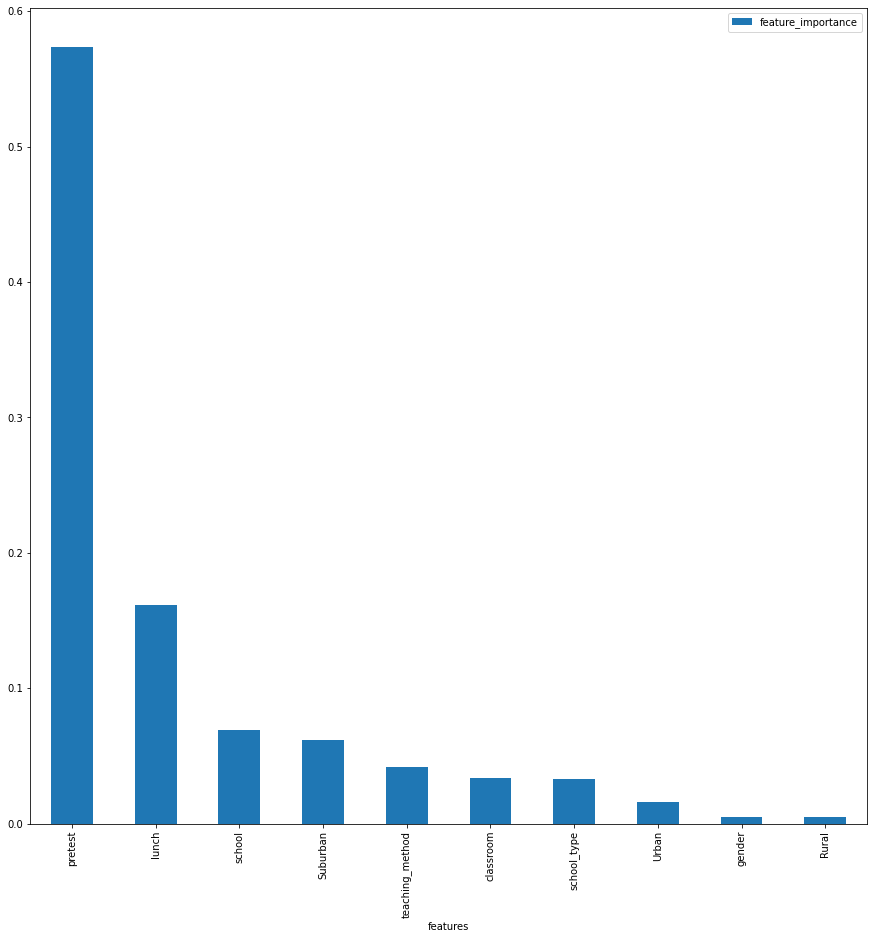

In [145]:
%matplotlib inline 
feature_dict_df.plot.bar(x='features' , y='feature_importance' , figsize=(15,15) )
plt.show()

To close this off, we shall now try our best model on our train and test set and see how it performs.

In [146]:
best_model = RF_grid_search.best_estimator_


In [147]:

cross_val_score_train = cross_val_score(best_model, strat_train_treated_prepared , strat_train_treated_labels , scoring="neg_root_mean_squared_error", cv=10 )
cross_val_score_train = -cross_val_score_train
scores_breakdown(cross_val_score_train , name='train')

Mean and Standard deviation of the k-fold scores of the train set is 3.211105994209512 and 0.14330724018841387 respectively


In [148]:
cross_val_score_test = cross_val_score(best_model, strat_test_treated_prepared , strat_test_treated_labels , scoring="neg_root_mean_squared_error", cv=10)
cross_val_score_test = -cross_val_score_test
scores_breakdown(cross_val_score_test , name='test')

Mean and Standard deviation of the k-fold scores of the test set is 3.5747844244544638 and 0.40640358161175544 respectively


Let's visualize the discrepancy between our predicted and actual scores on both the train and test set.


In [149]:
best_model = RF_grid_search.best_estimator_

predictions_train_set = best_model.predict(strat_train_treated_prepared)
train_labels = strat_train_treated_labels.iloc[:,0].astype('int')

In [150]:
predictions_test_set = best_model.predict(strat_test_treated_prepared)
test_labels = strat_test_treated_labels.iloc[:,0].astype('int')

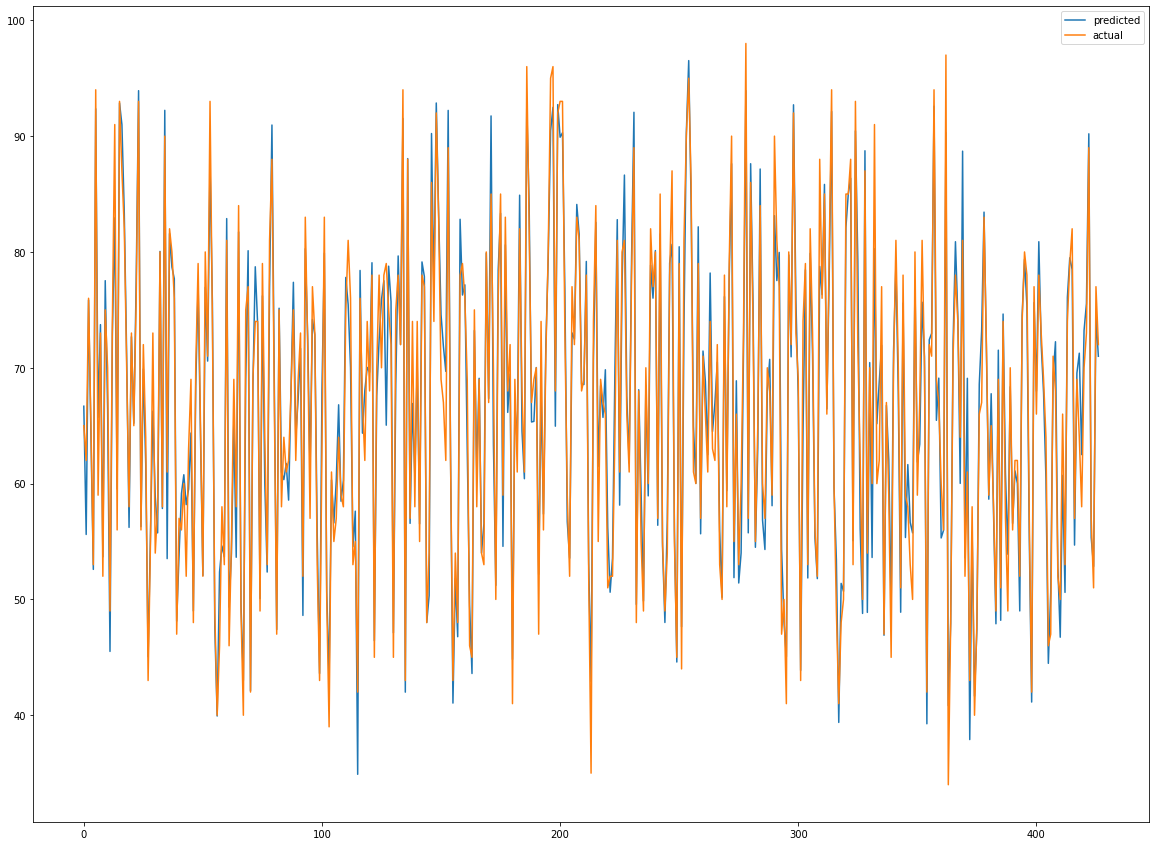

In [151]:
def plot_comparison(predictions,labels , split_plots=False):
  data_dict_predictedvactual = {
      'predicted':predictions,
      'actual':labels
  }
  predictedvactual = pd.DataFrame.from_dict(data_dict_predictedvactual )
  %matplotlib inline 
  predictedvactual.plot.line(figsize=(20,15) , subplots=split_plots)
  return plt.show()



plot_comparison(predictions_test_set ,test_labels )
